In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from keras.applications import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_rows, img_cols = 224, 224

MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

for layer in MobileNet.layers:
    layer.trainable = True

def addTopModelMobileNet(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

num_classes = 5
FC_Head = addTopModelMobileNet(MobileNet, num_classes)
model = Model(inputs=MobileNet.input, outputs=FC_Head)

print(model.summary())

data_dir = "/kaggle/input/mangos-data/MANGO DATASETS"

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 
)

batch_size = 32

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  
)

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'mangoripeness.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',  
    patience=5,
    verbose=1,
    factor=0.2,
    min_lr=0.0001
)

callbacks = [earlystop, checkpoint, learning_rate_reduction]

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

epochs = 25

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=validation_generator
)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,855,429 (22.34 MB)

 Trainable params: 5,833,541 (22.25 MB)

 Non-trainable params: 21,888 (85.50 KB)

None
Found 474 images belonging to 5 classes.
Found 118 images belonging to 5 classes.
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5247 - loss: 1.4312
Epoch 1: val_loss improved from inf to 10.59882, saving model to mangoripeness.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.5398 - loss: 1.3858 - val_accuracy: 0.2542 - val_loss: 10.5988 - learning_rate: 0.0010
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9952 - loss: 0.0333
Epoch 2: val_loss did not improve from 10.59882
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step - accuracy: 0.9947 - loss: 0.0351 - val_accuracy: 0.2542 - val_loss: 22.0277 - learning_rate: 0.0010
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9630 - loss: 0.1410
Epoch 3: val_loss improved from 10.59882 to 8.93968, saving model to mangoripeness.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 462ms/step - accuracy: 0.9626 - loss: 0.1420 - val_accuracy: 0.4237 - val_loss: 8.9397 - learning_rate: 0.0010
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9675 - loss: 0.2342
Epoch 4: val_loss impro

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 541ms/step - accuracy: 1.0000 - loss: 0.0117
Validation Loss: 0.0103
Validation Accuracy: 1.0000


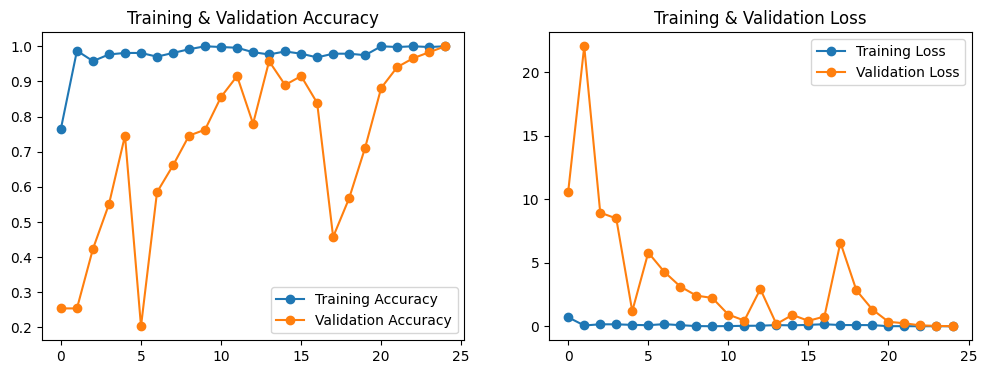

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

model = load_model(('mangorcatgry.h5')

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.show()


plot_training_history(history)


In [3]:
# Save the trained model in H5 format
model.save('mangorcatgry.h5')

print("Model saved successfully as 'mangoripeness.h5'")


Model saved successfully as 'mangoripeness.h5'
